<p><strong><font size="6">WALOUS</font></strong></p>

<p><strong><font size="6">Fusion LC classifications results</font></strong></p>

<p><strong><font size="6">Train machine learning model</font></strong></p>

This python code implement the method developed by ANAGEO (ULB). 

Code developped on Linux Mint 18.1 (Ubuntu Xenial 16.04) and GRASS GIS 7.3.svn (r71315).

# Table of Contents

<div id="toc"></div>

The following cell is a Javascript section of code for building the Jupyter notebook's table of content.

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Define working environment

**Import libraries**

In [2]:
# Import libraries needed for setting parameters of operating system 
import os
import sys
import csv
import tempfile

** Add folder with SCR provided belong to this notebook**

In [3]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

** Setup environment variables for TAIS DESKTOP (Linux Mint + GRASS Dev) **

Please edit the file in `../SRC/config.py`, containing the configuration parameters, according to your own computer setup. The following cell is used to run this file.



In [4]:
run ../SRC/config.py

In [5]:
print config_parameters

{'outputfolder_classifRF_tiles': '../../../Results/Classif_RF/classif_tiles', 'outputfolder_classifRF': '../../../Results/Classif_RF', 'outputfolder_Logfile': '../../../Results/Log_file', 'permanent_mapset': 'PERMANENT', 'outputfolder_training_sample': '../../../Results/Training_sample', 'locationepsg': '31370', 'outputfolder': '../../../Results', 'list_tiles': '../../../Results/list_tiles', 'pixel_classes_list': '../../../Results/pixel_classes_list', 'outputfolder_classifRF_csv': '../../../Results/Classif_RF/classif_csv', 'gisdb': '../../GRASSDATA', 'location': 'WALOUS_31370', 'outputfolder_classfeatures': '../../../Results/Classification_features', 'PYTHONLIB': '/usr/lib/python2.7', 'njobs': 6, 'rf_trained_model': '../../../Results/Classif_RF/rf_trained_model.rda', 'GISBASE': '/usr/lib/grass76'}


## Special functions

In [6]:
# Import function that check and create folder
from mkdir import check_create_dir

In [7]:
def CheckNumColCsv(fileList):
    import sys,os,csv
    error = False
    if len(fileList)<=1:
        sys.exit("This function require at least two .csv files.")
    # first file header
    filename = fileList[0]
    tile_num = os.path.splitext(os.path.basename(filename))[0].split("_")[-1]
    f=open(filename)
    reader = csv.reader(f)
    count_firstfile = len(reader.next())
    print "Expected number of columns to be found in all files is %s (correspond to tile '%s')"%(count_firstfile,tile_num)
    # now the rest of files
    for filename in fileList[1:]:
        tile_num = os.path.splitext(os.path.basename(filename))[0].split("_")[-1]
        f=open(filename)
        reader = csv.reader(f)
        count_column = len(reader.next())
        if count_column != count_firstfile:
            error = True
            print "ERROR: Tile '%s' has %s columns"%(tile_num,count_column)
    if not error:
        print "All the files have the same number of columns"
    else: 
        sys.exit()

In [8]:
def StackCsv(fileList,outfile,overwrite=False):
    import sys,os,csv
    if len(fileList)<=1:
        sys.exit("This function require at least two .csv files to be stacked together.")
    if os.path.isfile(outfile) and overwrite==False:
        print "File '"+str(outfile)+"' aleady exists and overwrite option is not enabled."
    else:
        if overwrite==True:
            if os.path.exists(outfile):
                os.remove(outfile)
        stacked_csv=open(outfile,"a")  #Open in mode 'append'
        # first file including header:
        for line in open(fileList[0]):
            if len(line.split("\n")[0])>0:
                stacked_csv.write(line)
        # now the rest without header:
        for filename in fileList[1:]:
            f=open(filename)
            header = f.next() # skip the header
            for line in f:
                if len(line.split("\n")[0])>0:
                    stacked_csv.write(line)
            f.close() # not really needed
        stacked_csv.close()
        print str(len(fileList))+" individual .csv files will be stacked each other."

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

## Create new directories

In [9]:
# Check and create folder if needed
check_create_dir(config_parameters['outputfolder_classfeatures'])
check_create_dir(config_parameters['outputfolder_Logfile'])
check_create_dir(config_parameters['outputfolder_classifRF'])
check_create_dir(config_parameters['outputfolder_classifRF_csv'])
check_create_dir(config_parameters['outputfolder_classifRF_tiles'])

The folder '../../../Results/Classification_features' already exists
The folder '../../../Results/Log_file' already exists
The folder '../../../Results/Classif_RF' already exists
The folder '../../../Results/Classif_RF/classif_csv' already exists
The folder '../../../Results/Classif_RF/classif_tiles' already exists


# Collect training data

## Get list of segment ID

In [10]:
# Read csv
csvfile = os.path.join(config_parameters['outputfolder_training_sample'],"training_points_with_segid.csv")
fin = open(csvfile)
reader = csv.reader(fin)
# Get list of seg_ID
list_segid = []
label_dic = {}
reader.next()
for row in reader:
    tilegid = row[-1] # row[-1] for 'tilegid'
    segid = row[-2] # row[-2] for 'seg_id'
    label = row[-3]  # row[-3] for label 'label_2018'
    if tilegid != "" and segid != "":
        twokeyid = "%s_%s"%(segid,tilegid)
        list_segid.append(twokeyid)   
        label_dic[twokeyid] = label
initial_count = len(list_segid)
# Keep only value that appear once
count = [list_segid.count(a) for a in list_segid]  # Get list of count for each value
list_segid = [list_segid[i] for i,a in enumerate(count) if a == 1]   # Keep only where count = 1
list_segid = [(x.split("_")[0],x.split("_")[1], label_dic["%s_%s"%(x.split("_")[0],x.split("_")[1])]) for x in list_segid]
unique_count = len(list_segid)

# Create dictionnary with unique segments+tile ID
training_dic = {}
segid_list, tileid_list, label_list = zip(*list_segid)
for segid, tileid, label in zip(segid_list, tileid_list, label_list):
    if tileid not in training_dic:
        training_dic[tileid] = {}
    training_dic[tileid][segid] = label
    if "" in training_dic[tileid]:
        del training_dic[tileid][""]
if "" in training_dic:
    del training_dic[""]
    
# Print
print "%s segments out of the %s initially available will be used for training."%(unique_count,initial_count)

1382 segments out of the 1403 initially available will be used for training.


## Get single .csv with features of all tiles

In [10]:
# Get list of csv with classification feature of individual tiles
import glob
list_feature_csv = glob.glob(os.path.join(config_parameters['outputfolder_classfeatures'],"features_tile_*.csv"))
print "%s .csv files with classification feature in folder"%len(list_feature_csv)

# Verify if all .csv files have the same number of columns
CheckNumColCsv(list_feature_csv)

369 .csv files with classification feature in folder
Expected number of columns to be found in all files is 29 (correspond to tile '5920')
All the files have the same number of columns


## Get file with training sample (features + label)

In [17]:
# Define path to training file
trainingfile = os.path.join(config_parameters['outputfolder_training_sample'],"training_samples.csv")

In [13]:
import os,sys
overwrite=True
outputcsv = trainingfile
# Check
if os.path.isfile(outputcsv) and overwrite==False:
    print "File '"+str(outputcsv)+"' aleady exists and overwrite option is not enabled."
    sys.exit()
else:
    if os.path.isfile(outputcsv) and overwrite==True:
        open(outputcsv,"r").close
        os.remove(outputcsv)

# Initialization
available_csv = [os.path.split(a)[1].split(".csv")[0].split("_")[-1] for a in list_feature_csv]
remaining_dic = training_dic
select_dic = {}
found_counter=0  #To count how many items will be find
fout = open(outputcsv,"a")  #Output csv
writer = csv.writer(fout)   #Writer for output
first_file = True
# Start looking in list of .csv files
for tileid in training_dic:
    if tileid in available_csv:
        featurecsv = os.path.join(config_parameters['outputfolder_classfeatures'],"features_tile_%s.csv"%tileid)
        fin = open(featurecsv,"r")
        reader = csv.reader(fin)
        if first_file:  # If first .csv in the list
            header = reader.next()
            header.append("training_label")  # Add "training_label" as column name in last position of the header
            writer.writerow(header)
            first_file = False
        for line in reader:
            current_segid=line[0]
            if current_segid in training_dic[tileid]:
                label = training_dic[tileid][current_segid]
                newrow = line
                newrow.append(label)  # Add the label in last position of the new row
                writer.writerow(newrow)
                found_counter+=1
                del remaining_dic[tileid][current_segid]
                if label not in select_dic:
                    select_dic[label] = []
                select_dic[label].append(1)
fout.close()
count_remain = len([remaining_dic[subdic][key] for subdic in remaining_dic for key in remaining_dic[subdic]])
if found_counter==0:
    print "ERROR: Nothing found"
    os.remove(outputcsv)
    sys.exit()
if count_remain>0:  #If the research goes through all the .csv files in the list but still remain unfind items
    print "WARNING: %s item(s) not found."%count_remain
print "Process finished"

Process finished


## Restart the 'cat' id from scratch

Restart the 'cat' id from scratch to avoid duplicate (in case two segment from different tiles have the same id)

In [14]:
with open(trainingfile, 'r') as readFile:
    reader = csv.reader(readFile)
    header = reader.next()
    lines = list(reader)

for i, row in enumerate(lines, 1):
    row[0] = i

with open(trainingfile, 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(header)
    writer.writerows(lines)

readFile.close()
writeFile.close()

## Count of point in each class

In [15]:
print "Number of samples per class \n\n"
for label in select_dic:
    print "Class '%s'        %s samples"%(label,sum(select_dic[label]))

Number of samples per class 


Class '11'        225 samples
Class '12'        75 samples
Class '42'        273 samples
Class '41'        172 samples
Class '3'        56 samples
Class '2'        103 samples
Class '5'        420 samples
Class '6'        58 samples


# Train random forest model (R)

### Define parameters for the R script

In [11]:
## Set the path to the output of random forest classification
output_accuracy=os.path.join(config_parameters['outputfolder_classifRF'],"accuracy_RF.csv")
output_varimp=os.path.join(config_parameters['outputfolder_classifRF'],"VariablesImportance_RF.pdf")
output_rfmodel=os.path.join(config_parameters['outputfolder_classifRF'],"RF_model.txt")
output_cv=os.path.join(config_parameters['outputfolder_classifRF'],"RF_cv.pdf")

In [12]:
# Column name with label in training file
train_label = "training_label"

In [13]:
# Set number of cores
r_ncores = 5

### Create R script for the training

In [18]:
# Create and open new temporary R script
r_commands = os.path.join(config_parameters['outputfolder_classifRF'],"Fusion_walous_RF_Train.R").replace("\\", "/")
r_file = open(r_commands, 'w')

In [19]:
# Create a list with all lines to write in the script
r_instuction = []

# Piece of R script for intallation of R package
install_package = "if(!is.element('%s', installed.packages()[,1])){\n"
install_package += "cat('\\n\\nInstalling %s package from CRAN\n')\n"
install_package += "if(!file.exists(Sys.getenv('R_LIBS_USER'))){\n"
install_package += "dir.create(Sys.getenv('R_LIBS_USER'), recursive=TRUE)\n"
install_package += ".libPaths(Sys.getenv('R_LIBS_USER'))}\n"
install_package += "chooseCRANmirror(ind=1)\n"
install_package += "install.packages('%s', dependencies=TRUE)}"
r_instuction.append(install_package % ('doParallel', 'doParallel', 'doParallel')) #Package for parallel processing in R
r_instuction.append(install_package % ('caret', 'caret', 'caret')) #Package for machine learning in R
r_instuction.append(install_package % ('e1071', 'e1071', 'e1071')) 
r_instuction.append(install_package % ('randomForest', 'randomForest', 'randomForest')) #Package for Random Forest
r_instuction.append(install_package % ('pROC', 'pROC', 'pROC')) 

# Piece of R script for loading libraries and dependencies
lib_require = "library(%s)\n"
lib_require += "require(%s)"
r_instuction.append(lib_require % ('parallel', 'parallel')) 
r_instuction.append(lib_require % ('doParallel', 'doParallel')) 
r_instuction.append(lib_require % ('caret', 'caret')) 
r_instuction.append(lib_require % ('randomForest', 'randomForest')) 
r_instuction.append(lib_require % ('e1071', 'e1071')) 
r_instuction.append(lib_require % ('pROC', 'pROC')) 

# Set number of cores to use
r_instuction.append("# Set number of cores to use")
r_instuction.append("usedcores=%s"%r_ncores)
#r_instuction.append("usedcores=detectCores()-5")
r_instuction.append("registerDoParallel(usedcores)")

# Import training
r_instuction.append("# Import training")
r_instuction.append("training <- read.csv('%s', sep=',', header=TRUE, row.names=1)"%trainingfile.replace("\\", "/"))
# Define factor
r_instuction.append("# Define factor")
r_instuction.append("training$%s <- as.factor(training$%s)"%(train_label,train_label))

# Cross-validation setting
r_instuction.append("# Cross-validation setting")
r_instuction.append("MyFolds.cv <- createMultiFolds(training$%s, k=5, times=10)"%train_label)
r_instuction.append("MyControl.cv <- trainControl(method='repeatedCV', index=MyFolds.cv, allowParallel = TRUE)")

# Train Random Forest
r_instuction.append("# Train Random Forest")
r_instuction.append("rfModel <- train(%s~.,training,method='rf', trControl=MyControl.cv,tuneLength=10)"%train_label)
r_instuction.append("resamps.cv <- rfModel$resample")
r_instuction.append("accuracy_means <- mean(resamps.cv$Accuracy)")
r_instuction.append("kappa_means <- mean(resamps.cv$Kappa)")
r_instuction.append("df_means <- data.frame(method='rf',accuracy=accuracy_means, kappa=kappa_means)")
r_instuction.append("write.csv(df_means, '%s', row.names=FALSE, quote=FALSE)"%output_accuracy.replace("\\", "/"))

# Plot variable importance
r_instuction.append("# Plot variable importance")
r_instuction.append("importance <- varImp(rfModel, scale=FALSE)")
#r_instuction.append("pdf('%s', width = 11, height = ncol(features)/6 )"%output_varimp.replace("\\", "/"))
r_instuction.append("pdf('%s', width = 11, height = ncol(training)/6 )"%output_varimp.replace("\\", "/"))
r_instuction.append("print(plot(importance))")
r_instuction.append("dev.off()")

# Show final model
r_instuction.append("# Show final model")
r_instuction.append("tmp<-rfModel$finalModel")
r_instuction.append("sink('%s')"%output_rfmodel.replace("\\", "/"))
r_instuction.append("print(tmp)")
r_instuction.append("sink()")

# Plot cross validation tuning results
r_instuction.append("# Plot cross validation tuning results")
r_instuction.append("pdf('%s')"%output_cv.replace("\\", "/"))
r_instuction.append("print(plot(rfModel))")
r_instuction.append("dev.off()")

# Export trained model in file
r_instuction.append("# Export trained model in file")
r_instuction.append("saveRDS(rfModel, file = '%s')"%config_parameters['rf_trained_model'].replace("\\", "/"))

# Write instructions to the R script file
r_file.write("\n".join(r_instuction))
r_file.close()

### Execute R script

In [21]:
import subprocess

In [22]:
print "Running R now. Following output is R output."
try:
    subprocess.check_call(['Rscript', r_commands], stderr=subprocess.STDOUT, )
except subprocess.CalledProcessError:
    print "There was an error in the execution of the R script.\nPlease check the R output."
print "Finished running R."

Running R now. Following output is R output.
Finished running R.


### Display results of R

In [23]:
import pandas as pd 
#### Show mean accuracy results from cross-validation for tuning
## Import .csv file
accuracy=pd.read_csv(output_accuracy, sep=',',header=0)
## Display table
accuracy.head(15)

,method,accuracy,kappa
0,rf,0.728431,0.659892


In [24]:
#### Import classifiers tuning parameters and confusion matrix
## Open file
classifier_runs = open(output_rfmodel, 'r')  
## Read file
print classifier_runs.read()


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 26.99%
Confusion matrix:
   2  3   5  6  11 12  41  42 class.error
2  5  4  38  2  38  0   9   7   0.9514563
3  3 18  35  0   0  0   0   0   0.6785714
5  1  6 357  4  12  0  16  24   0.1500000
6  0  1   0 42   5  1   2   7   0.2758621
11 3  0  10  4 188 17   0   3   0.1644444
12 0  0   1  0  16 56   0   2   0.2533333
41 0  0  11  0   0  0 137  24   0.2034884
42 0  0  40  2   1  1  23 206   0.2454212



The following cell display pdf figures. Please first install the **Wand** package using the folowwing command in the terminal : 

``` sudo pip instal Wand ```

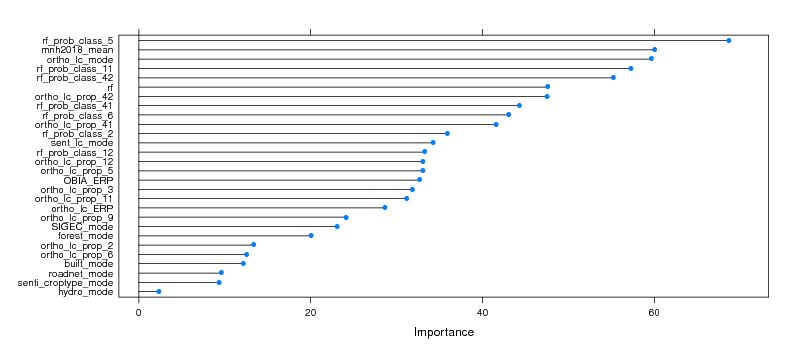

In [25]:
## Display graphs
import wand
from wand.image import Image as WImage
img = WImage(filename=output_varimp)
img

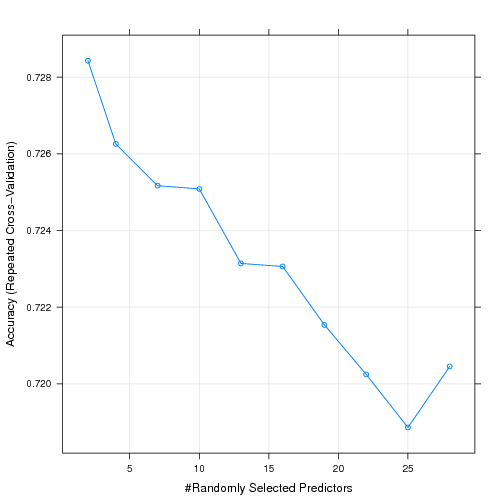

In [26]:
## Display graphs
import wand
from wand.image import Image as WImage
img = WImage(filename=output_cv)
img